In [1]:
import sys

if ".." not in sys.path:
    sys.path.append("..")

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import pickle
import pymc as pm
import numpy as np
import scipy.integrate as spi
import pytensor
import pytensor.tensor as pt

from tqdm import tqdm
from utils.math import get_interpolator
from utils.colors import *

DATA_FILE = "../data/clean/CUE2/dFBA.pkl"

# Load condition data
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

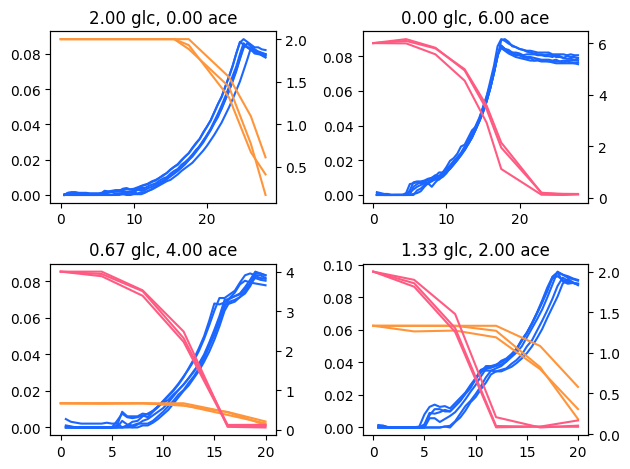

In [3]:
fig, axs = plt.subplots(2, 2)

for ax, ((glucose, acetate), dat) in zip(axs.flat, data.items()):
    b_t = dat["raw"]["raw_b_t"]
    g_t = dat["raw"]["raw_g_t"].values
    a_t = dat["raw"]["raw_a_t"].values
    b_s = dat["raw"]["raw_b"]
    g_s = dat["raw"]["raw_g_s"]
    a_s = dat["raw"]["raw_a_s"]
    
    tmax = min(b_t[-1], g_t[-1], a_t[-1])

    ax.plot(b_t[b_t <= tmax], b_s[:, b_t <= tmax].T, color=C_BIOMASS)
    ax2 = ax.twinx()
    ax2.plot(g_t[g_t <= tmax], g_s[:, g_t <= tmax].T, color=C_GLUCOSE)
    ax2.plot(a_t[a_t <= tmax], a_s[:, a_t <= tmax].T, color=C_ACETATE)

    ax.set_title(f"{glucose.magnitude:.2f} glc, {acetate.magnitude:.2f} ace")

fig.tight_layout()

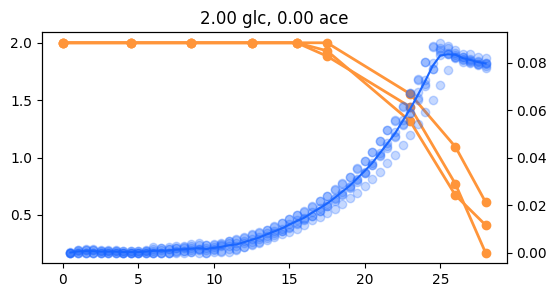

In [4]:
# Start with just glucose condition
condition = list(data.keys())[0]
dat = data[condition]
N0 = condition[0].magnitude

# Get raw data
t_X_obs = dat["raw"]["raw_b_t"]
X_obs_replicates = dat["raw"]["raw_b"]
t_N_obs = dat["raw"]["raw_g_t"]
N_obs_replicates = dat["raw"]["raw_g_s"]

# Plot data function for use later
def plot_data(ax, lw=2):
    ax.plot(t_N_obs, N_obs_replicates.T, marker="o", lw=lw, color=C_GLUCOSE)
    ax2 = ax.twinx()
    ax2.plot(t_X_obs, X_obs_replicates.T, marker="o", lw=0, color=C_BIOMASS, alpha=0.25)
    ax2.plot(t_X_obs, X_obs_replicates.mean(axis=0), color=C_BIOMASS)   
    ax.set_title(f"{condition[0].magnitude:.2f} glc, {condition[1].magnitude:.2f} ace")

fig, ax = plt.subplots(figsize=(6, 3))
plot_data(ax)


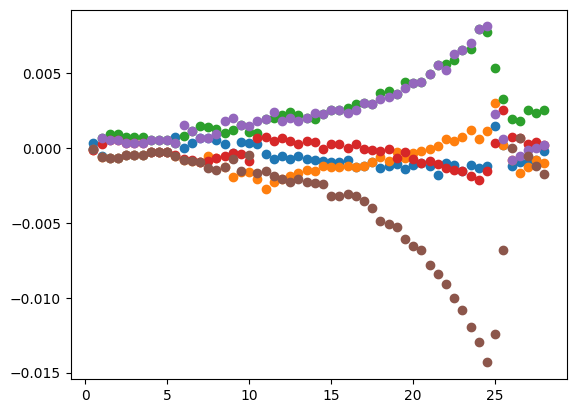

In [5]:
# In principle, we could model the X observations as noisy measurements
# of the latent, "true" X. However, this is a lot of variables to introduce,
# especially since the X measurements are not paired with the N measurements
# (we have 6 X replicates, and 3 N replicates).
# 
# Alternatively, we can take some estimate of the true X, and feed that in
# as a deterministic given to the Bayesian model.
# To do so, let's first look at the error structure - how are replicates
# distributed around the mean at a given timepoint?

X_true_estimated = X_obs_replicates.mean(axis=0)
fig, ax = plt.subplots()
ax.plot(t_X_obs, (X_obs_replicates - X_true_estimated).T, marker="o", lw=0)

In [6]:
from numba import njit

# define the right hand side of the ODE equations in the Scipy odeint signature
@njit
def michaelis_menten(N, t, theta, X=X_true_estimated, t_X_obs = t_X_obs):
    # unpack parameters
    V_max = theta[0]
    K_M = theta[1]
    # equations
    X_t = np.interp(t, t_X_obs, X)
    return -V_max * (N / (K_M + N)) * X_t

In [7]:
# plot model function
def plot_model(
    ax,
    N,
    time=t_N_obs,
    alpha=1,
    lw=3,
    c=C_GLUCOSE,
    label="Glucose (Model)"
):
    ax.plot(time, N, color=c, alpha=alpha, lw=lw, label=label)
    return ax

<Axes: title={'center': '2.00 glc, 0.00 ace'}>

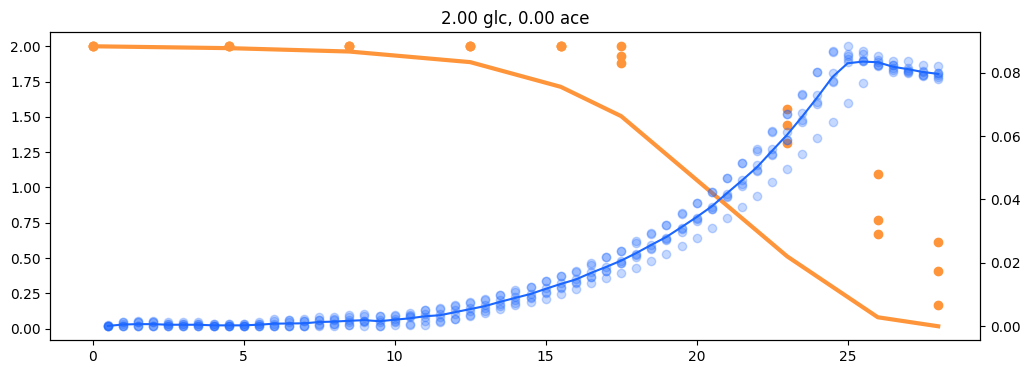

In [8]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

# note theta = V_max, K_M
theta = np.array([10, 1])

# call Scipy's odeint function
N_sim = odeint(func=michaelis_menten, y0=N0, t=t_N_obs, args=(theta,)).flatten()

# plot
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, N_sim)

Submitting...: 100%|██████████| 400/400 [00:00<00:00, 3005.62it/s]
Collecting...: 400it [00:00, 74219.05it/s]


Text(0, 0.5, '$\\log(K_M)$')

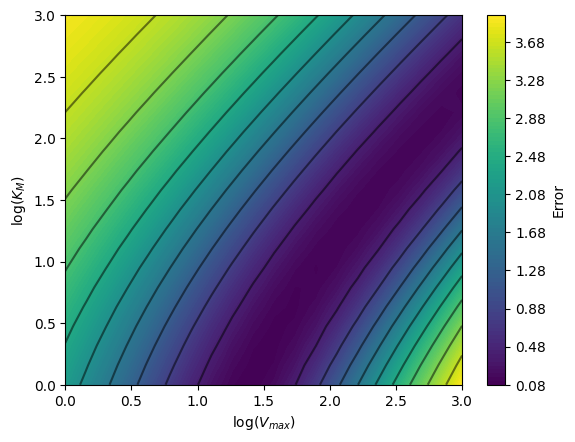

In [9]:
from concurrent.futures import ProcessPoolExecutor, as_completed
# That wasn't informative enough - let's plot the error surface

# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    log_V_max, log_K_M = theta
    N_resid = ((N_obs_replicates.mean(axis=0))
               - (odeint(func=michaelis_menten,
                        y0=N0,
                        t=t_N_obs,
                        args=(
                            (np.exp(log_V_max), np.exp(log_K_M)),
                        )).flatten())
               )
    return N_resid

# function that calculates SSE for given theta
def ode_model_sse(theta):
    return np.sum(ode_model_resid(theta)**2)

# plot the error surface
V_max = np.linspace(0, 3, 20)
K_M = np.linspace(0, 3, 20)
V_max, K_M = np.meshgrid(V_max, K_M)
SSE = np.zeros_like(V_max)

with ProcessPoolExecutor() as executor:
    futures = {}
    with tqdm(total=V_max.shape[0] * V_max.shape[1], desc="Submitting...") as pbar:        
        for i in range(V_max.shape[0]):
            for j in range(V_max.shape[1]):
                future = executor.submit(ode_model_sse, (V_max[i, j], K_M[i, j]))
                futures[future] = (i, j)
                pbar.update(1)

for future in tqdm(as_completed(futures), "Collecting..."):
    i, j = futures[future]
    SSE[i, j] = future.result()

fig, ax = plt.subplots()
c = ax.contourf(V_max, K_M, SSE, levels=100)
ax.contour(V_max, K_M, SSE, levels=10, colors="k", alpha=0.5)
fig.colorbar(c, label="Error")
ax.set_xlabel("$\\log(V_{{max}})$")
ax.set_ylabel("$\\log(K_M)$")

Text(0, 0.5, '$K_M$')

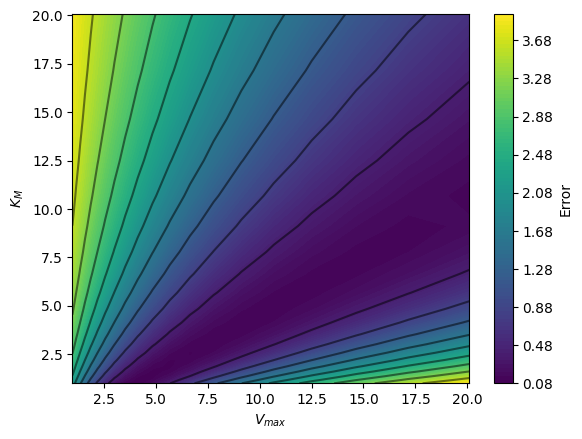

In [28]:
fig, ax = plt.subplots()
c = ax.contourf(np.exp(V_max), np.exp(K_M), SSE, levels=100)
ax.contour(np.exp(V_max), np.exp(K_M), SSE, levels=10, colors="k", alpha=0.5)
fig.colorbar(c, label="Error")
ax.set_xlabel("$V_{{max}}$")
ax.set_ylabel("$K_M$")

In [23]:
# Optimization with least squares

import pandas as pd
from scipy.optimize import least_squares

# note theta = V_max, log(K_M)
theta = np.array([np.log(5), np.log(2)])

# function that calculates residuals based on a given theta
def ode_model_resid(theta):
    log_V_max, log_K_M = theta
    N_resid = ((N_obs_replicates.mean(axis=0))
               - (odeint(func=michaelis_menten,
                        y0=N0,
                        t=t_N_obs,
                        args=(
                            (np.exp(log_V_max), np.exp(log_K_M)),
                        )).flatten())
               )
    return N_resid


# calculate least squares using the Scipy solver
results = least_squares(ode_model_resid,
                        x0=theta,
                        bounds=([-1000, -1000], [1000, 1000]),
                        xtol=1e-12,
                        ftol=1e-12,
                        gtol=1e-12,
                        method="trf",
                        verbose=2)

# put the results in a dataframe for presentation and convenience
df = pd.DataFrame(
    {"Vmax": [results.x[0]],
     "log_K_M": [results.x[1]],
     "K_M": [np.exp(results.x[1])]},
)
df.round(2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.0899e-02                                    8.93e+03    
       1             19         7.0899e-02      0.00e+00       0.00e+00       8.93e+03    
`xtol` termination condition is satisfied.
Function evaluations 19, initial cost 7.0899e-02, final cost 7.0899e-02, first-order optimality 8.93e+03.


,Vmax,log_K_M,K_M
0,1.61,0.69,2.0


In [ ]:
# function that calculates SSE for given theta
def ode_model_sse(theta):
    return np.sum(ode_model_resid(theta)**2)

# Try minimze function instead of least_squares
from scipy.optimize import minimize

# note theta = V_max, log(K_M)
theta = np.array([np.log(5), np.log(2)])

results = minimize(ode_model_sse,
                     x0=theta,
                     bounds=((-1000, 1000), (-1000, 1000)),
                     method="L-BFGS-B")

results

  message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.09963936338442261
        x: [ 1.637e+00  4.973e-01]
      nit: 7
      jac: [ 5.563e+01  6.068e+01]
     nfev: 351
     njev: 117
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

Text(0, 0.5, '$\\log(K_M)$')

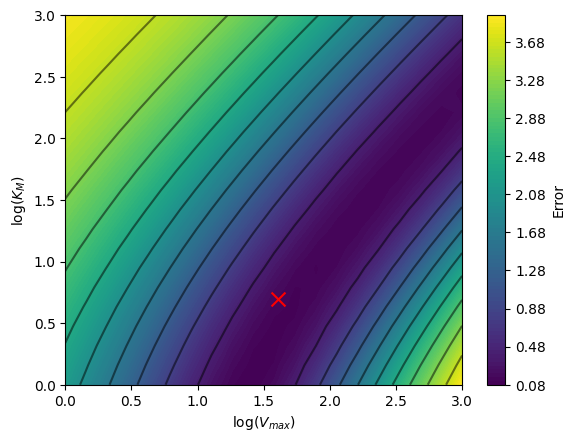

In [24]:
fig, ax = plt.subplots()
c = ax.contourf(V_max, K_M, SSE, levels=100)
ax.contour(V_max, K_M, SSE, levels=10, colors="k", alpha=0.5)
ax.scatter(results.x[0], results.x[1], color="r", marker="x", s=100)
fig.colorbar(c, label="Error")
ax.set_xlabel("$\\log(V_{{max}})$")
ax.set_ylabel("$\\log(K_M)$")

Text(0.5, 1.0, 'Least-Squares (10.0, 5.0)')

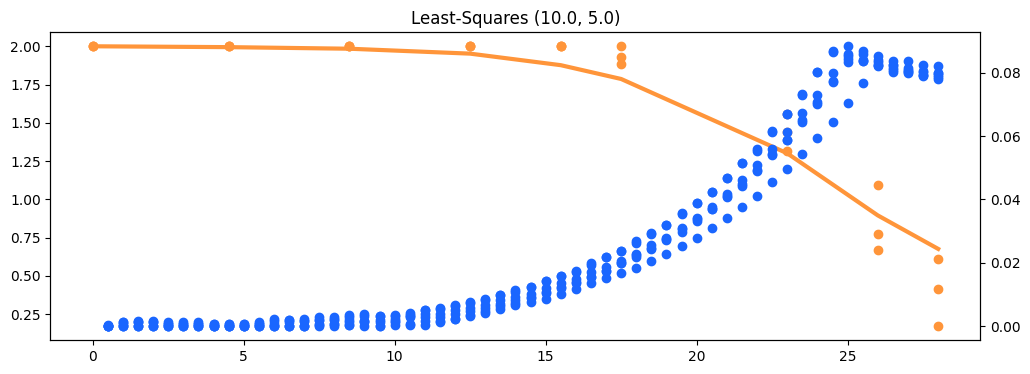

In [11]:
theta = (*results.x, *X_obs_replicates.mean(axis=0))
N_sim = odeint(func=michaelis_menten, y0=N0, t=t_N_obs, args=(theta,))
fig, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, N_sim)
ax.set_title(f"Least-Squares ({theta[0]}, {theta[1]})")

In [50]:
odeint(func=michaelis_menten, y0=N0, t=t_N_obs, args=(theta,)).flatten()

array([2.        , 1.99763297, 1.99330233, 1.9797132 , 1.94731669,
       1.90746188, 1.66722907, 1.41468817, 1.24313578])

In [46]:
from pytensor.compile.ops import as_op

# decorator with input and output types a Pytensor double float tensors
@as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
def pytensor_forward_model_matrix(theta):
    return odeint(func=michaelis_menten, y0=N0, t=t_N_obs, args=(theta,)).flatten()

In [55]:
theta = results.x  # least squares solution used to inform the priors
with pm.Model() as model:
    # Priors
    V_max = pm.TruncatedNormal("V_max", mu=theta[0], sigma=0.5, lower=0, initval=theta[0])
    K_M = pm.TruncatedNormal("K_M", mu=theta[1], sigma=0.5, lower=0, initval=theta[1])

    # standard deviation of the likelihood
    sigma = pm.HalfNormal("sigma", 1)

    # Ode solution function
    ode_solution = pytensor_forward_model_matrix(
        pm.math.stack([V_max, K_M])
    ).reshape((-1,))

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=N_obs_replicates.mean(axis=0))

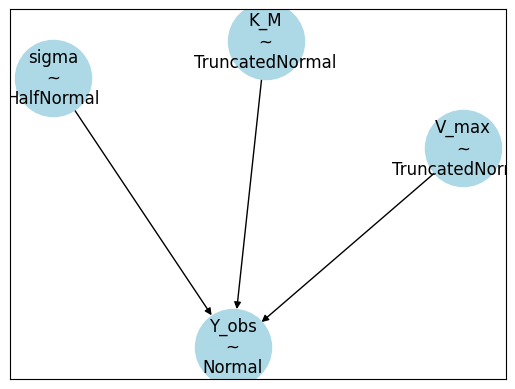

In [56]:
import networkx as nx

g = pm.model_to_networkx(model)
nx.draw_networkx(g,
                 with_labels=True,
                 labels={n: g.nodes[n]["label"] for n in g.nodes},
                 node_size=3000,
                 node_color="lightblue")

In [ ]:
# def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
#     cols = ["alpha", "beta", "gamma", "delta", "xto", "yto"]
#     row = trace_df.iloc[row_idx, :][cols].values

#     # alpha, beta, gamma, delta, Xt0, Yt0
#     time = np.arange(1900, 1921, 0.01)
#     theta = row
#     x_y = odeint(func=rhs, y0=theta[-2:], t=time, args=(theta,))
#     plot_model(ax, x_y, time=time, lw=lw, alpha=alpha)

In [ ]:
# def plot_inference(
#     ax,
#     trace,
#     num_samples=25,
#     title="Hudson's Bay Company Data and\nInference Model Runs",
#     plot_model_kwargs=dict(lw=1, alpha=0.2),
# ):
#     trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
#     plot_data(ax, lw=0)
#     for row_idx in range(num_samples):
#         plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
#     ax.set_title(title, fontsize=16)

In [57]:
# Variable list to give to the sample step parameter
vars_list = list(model.values_to_rvs.keys())[:-1]

In [ ]:
import arviz as az
from fastprogress import fastprogress
fastprogress.printing = lambda: True

sampler = "DEMetropolis"
chains = 8
draws = 6000
with model:
    trace_DEM = pm.sample(step=[pm.DEMetropolis(vars_list)], draws=draws, chains=chains)
trace = trace_DEM
az.summary(trace)

Population sampling (8 chains)
DEMetropolis: [V_max, K_M, sigma]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


/home/mica/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [ ]:
# Start with just glucose condition
condition = list(data.keys())[0]
dat = data[condition]
N0 = condition[0].magnitude

# Get raw data
t_obs = dat["raw"]["raw_b_t"]
X_obs_replicates = dat["raw"]["raw_b"]
N_obs_replicates = dat["raw"]["raw_g_s"]

# Define the derivative for the ODE
def michaelis_menten(N, t, V_max, K_M, X_t):
    return - V_max * (N / (K_M + N)) * X_t[t_obs == t]

# PyMC Model
with pm.Model() as model:

    # Priors on V_max and K_M
    V_max = pm.Normal("V_max", mu=10, sigma=2)
    K_M = pm.Normal("K_M", mu=5, sigma=1)

    # Priors on noise levels
    sigma_X = pm.HalfNormal("sigma_X", 0.1)
    sigma_N = pm.HalfNormal("sigma_N", 0.5)

    # Latent biomass values per timepoint
    X_true_latent = pm.Normal("X_true", mu=np.mean(X_obs_replicates, axis=0), sigma=sigma_X, shape=len(t_obs))

    # Solve ODE given inferred X
    def solve_ode(V_max, K_M, X_t):
        # return spi.odeint(michaelis_menten, N0, t_obs, args=(V_max, K_M, X_t)).flatten()
        result = [N0]
        for t, dt  in zip(t_obs[1:], np.diff(t_obs)):
            result.append(result[-1] + michaelis_menten(result[-1], t, V_max, K_M, X_t) * dt)
        return np.array(result)
    
    N_sim = solve_ode(V_max, K_M, X_true_latent)

    # Likelihood for replicates
    X_obs_likelihood = pm.Normal("X_obs", mu=X_true_latent, sigma=sigma_X, observed=X_obs_replicates)
    N_obs_likelihood = pm.Normal("N_obs", mu=N_sim, sigma=sigma_N, observed=N_obs_replicates)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Model Diagnostics
import arviz as az
az.summary(trace)

TypeError: Unsupported dtype for TensorType: object

In [24]:
N_sim[1]

Add.0

In [28]:
X_obs_replicates[0]

array([1.0170017 , 0.89071451, 0.88462632, 0.83458413, 0.75177896,
       0.68576252, 0.65765956, 0.61021041, 0.56991845, 0.48654631,
       0.49207596, 0.43187628, 0.42958096, 0.3831592 , 0.39893082])

In [ ]:
import pymc as pm
import numpy as np
import scipy.integrate as spi
from scipy.interpolate import interp1d

# Define the ODE
def michaelis_menten(N, t, V_max, K_M, X_interp):
    X_t = X_interp(t)  # Interpolated X at time t
    return - (V_max * N / (K_M + N)) * X_t

# Simulated Data
t_obs = np.linspace(0, 10, 15)  # Observation times
num_replicates = 3

# True biomass trajectory (simulated)
X_true = np.exp(-0.1 * t_obs)

# Generate noisy replicate data
X_obs_replicates = np.array([
    X_true + np.random.normal(0, 0.02, len(t_obs)) for _ in range(num_replicates)
])

# True parameters for V_max and K_M
true_params = {"V_max": 10, "K_M": 5}
N0 = 10  # Initial substrate concentration

# Solve ODE for each replicate of X
N_obs_replicates = []
for i in range(num_replicates):
    X_interp = interp1d(t_obs, X_obs_replicates[i], kind='linear', fill_value="extrapolate")
    N_solution = spi.odeint(michaelis_menten, N0, t_obs, args=(true_params["V_max"], true_params["K_M"], X_interp))
    N_obs_replicates.append(N_solution.flatten() + np.random.normal(0, 0.5, len(t_obs)))

N_obs_replicates = np.array(N_obs_replicates)  # Convert to numpy array

# PyMC Model
with pm.Model() as model:
    
    # Priors on V_max and K_M
    V_max = pm.Normal("V_max", mu=10, sigma=2)
    K_M = pm.Normal("K_M", mu=5, sigma=1)

    # Priors on noise levels
    sigma_X = pm.HalfNormal("sigma_X", 0.1)
    sigma_N = pm.HalfNormal("sigma_N", 0.5)

    # Latent biomass values per timepoint
    X_true_latent = pm.Normal("X_true", mu=np.mean(X_obs_replicates, axis=0), sigma=sigma_X, shape=len(t_obs))

    # Solve ODE given inferred X
    def solve_ode(V_max, K_M, X_t_values):
        X_interp = interp1d(t_obs, X_t_values, kind='linear', fill_value="extrapolate")
        return spi.odeint(michaelis_menten, N0, t_obs, args=(V_max, K_M, X_interp)).flatten()

    N_sim = solve_ode(V_max, K_M, X_true_latent)

    # Likelihood for replicates
    X_obs_likelihood = pm.Normal("X_obs", mu=X_true_latent, sigma=sigma_X, observed=X_obs_replicates)
    N_obs_likelihood = pm.Normal("N_obs", mu=N_sim, sigma=sigma_N, observed=N_obs_replicates)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Model Diagnostics
import arviz as az
az.summary(trace)


RuntimeError: The size of the array returned by func (15) does not match the size of y0 (1).

In [49]:
import pymc as pm
import numpy as np
import scipy.integrate as spi
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

# Define the ODE function
def michaelis_menten(N, t, V_max, K_M, X_interp):
    """Michaelis-Menten substrate uptake model"""
    X_t = X_interp(t)  # Interpolated X at time t
    return - (V_max * N / (K_M + N)) * X_t

# Simulated Data
t_obs = np.linspace(0, 10, 15)  # Observation times
num_replicates = 3

# True biomass trajectory (simulated)
X_true = np.exp(-0.1 * t_obs)

# Generate noisy replicate data
X_obs_replicates = np.array([
    X_true + np.random.normal(0, 0.02, len(t_obs)) for _ in range(num_replicates)
])

# True parameters for V_max and K_M
true_params = {"V_max": 10, "K_M": 5}
N0 = 10  # Initial substrate concentration

# Solve ODE for each replicate of X using interpolation
N_obs_replicates = []
for i in range(num_replicates):
    X_interp = lambda t: np.interp([t], t_obs, X_obs_replicates[i])  # Interpolate X(t)
    N_solution = spi.odeint(michaelis_menten, N0, t_obs, args=(true_params["V_max"], true_params["K_M"], X_interp))
    N_obs_replicates.append(N_solution.flatten() + np.random.normal(0, 0.5, len(t_obs)))

N_obs_replicates = np.array(N_obs_replicates)  # Convert to numpy array

# Define a PyMC Op for solving the ODE using PyTensor
@as_op(itypes=[pt.dscalar, pt.dscalar, pt.dvector], otypes=[pt.dvector])
def solve_ode_pytensor(V_max, K_M, X_t_values):
    """Solves the Michaelis-Menten ODE using PyTensor-compatible inputs"""
    X_interp = lambda t: np.interp([t], t_obs, X_t_values)  # Create an interpolated function
    N_solution = spi.odeint(michaelis_menten, N0, t_obs, args=(V_max, K_M, X_interp)).flatten()
    return N_solution

# PyMC Model
with pm.Model() as model:
    
    # Priors on V_max and K_M
    V_max = pm.Normal("V_max", mu=10, sigma=2)
    K_M = pm.Normal("K_M", mu=5, sigma=1)

    # Priors on noise levels
    sigma_X = pm.HalfNormal("sigma_X", 0.1)
    sigma_N = pm.HalfNormal("sigma_N", 0.5)

    # Latent biomass values per timepoint
    X_true_latent = pm.Normal("X_true", mu=np.mean(X_obs_replicates, axis=0), sigma=sigma_X, shape=len(t_obs))

    # Solve ODE given inferred X using the custom PyTensor Op
    N_sim = solve_ode_pytensor(V_max, K_M, X_true_latent)

    # Likelihood for replicates
    X_obs_likelihood = pm.Normal("X_obs", mu=X_true_latent, sigma=sigma_X, observed=X_obs_replicates)
    N_obs_likelihood = pm.Normal("N_obs", mu=N_sim, sigma=sigma_N, observed=N_obs_replicates)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Model Diagnostics
import arviz as az
az.summary(trace)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [V_max]
>>Slice: [K_M]
>NUTS: [sigma_X, sigma_N]
>Metropolis: [X_true]


/home/mica/.pyenv/versions/3.12.1/envs/rpom/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/tmp/ipykernel_10804/3201265955.py:43: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  N_solution = spi.odeint(michaelis_menten, N0, t_obs, args=(V_max, K_M, X_interp)).flatten()


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1086769989772D+01   r2 =  0.5697133977397D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1086769989772D+01   r2 =  0.5697133977397D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1086769989772D+01   r2 =  0.5697133977397D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1086769989772D+01   r2 =  0.5697133977397D-16
 lsoda--  warning..internal t (=r1) 

/tmp/ipykernel_10804/3201265955.py:43: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  N_solution = spi.odeint(michaelis_menten, N0, t_obs, args=(V_max, K_M, X_interp)).flatten()


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1167700517262D+01   r2 =  0.5394067081846D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1167700517262D+01   r2 =  0.1348516770461D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1167700517262D+01   r2 =  0.1348516770461D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1167700517262D+01   r2 =  0.1348516770461D-16
 lsoda--  warning..internal t (=r1) 

/tmp/ipykernel_10804/3201265955.py:43: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  N_solution = spi.odeint(michaelis_menten, N0, t_obs, args=(V_max, K_M, X_interp)).flatten()


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015518683433D+01   r2 =  0.6630439055498D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015518683433D+01   r2 =  0.6630439055498D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015518683433D+01   r2 =  0.6630439055498D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015518683433D+01   r2 =  0.3075015983462D-16
 lsoda--  warning..internal t (=r1) 

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1193 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
V_max,10.463,0.907,8.742,12.138,0.028,0.020,1047.0,1902.0,1.00
K_M,5.397,0.858,3.813,6.984,0.027,0.019,1025.0,1844.0,1.00
X_true[0],1.013,0.009,0.996,1.029,0.000,0.000,873.0,944.0,1.01
X_true[1],0.948,0.009,0.930,0.964,0.000,0.000,1054.0,994.0,1.01
X_true[2],0.867,0.009,0.851,0.885,0.000,0.000,999.0,940.0,1.01
X_true[3],0.799,0.009,0.783,0.815,0.000,0.000,1114.0,1142.0,1.02
X_true[4],0.760,0.008,0.745,0.776,0.000,0.000,609.0,654.0,1.02
X_true[5],0.702,0.009,0.683,0.718,0.000,0.000,854.0,691.0,1.01
X_true[6],0.636,0.009,0.619,0.652,0.000,0.000,1000.0,921.0,1.00
X_true[7],0.609,0.009,0.594,0.627,0.000,0.000,765.0,1121.0,1.00


In [47]:
X_interp

array([1.01571395, 0.91527187, 0.8906702 , 0.80139462, 0.7370399 ,
       0.70532608, 0.65089164, 0.63096592, 0.55967068, 0.52080105,
       0.49622998, 0.46506363, 0.43204582, 0.39379653, 0.3671241 ])

In [34]:
interp1d(t_obs, np.mean(X_obs_replicates, axis=0), kind='linear', fill_value="extrapolate")

In [45]:
michaelis_menten(1, 1, 1, 1, 1)

-0.5

In [44]:
spi.odeint(michaelis_menten, N0, t_obs, args=(10, 3, np.mean(X_obs_replicates, axis=0))).flatten()

RuntimeError: The size of the array returned by func (56) does not match the size of y0 (1).

In [ ]:
# Plot dS/dt
fig, axs = plt.subplots(2, 2)

for ax, ((glucose, acetate), dat) in zip(axs.flat, data.items()):
    b_t = dat["mean"]["b_t"]
    g_t = dat["mean"]["g_t"].values
    a_t = dat["mean"]["a_t"].values
    b_s = dat["mean"]["b_s"]
    g_s = dat["mean"]["g_s"]
    a_s = dat["mean"]["a_s"]

    dg_dt = np.diff(g_s) / np.diff(g_t)
    da_dt = np.diff(a_s) / np.diff(a_t)
    g_t = g_t[:-1]
    a_t = a_t[:-1]
    
    tmax = min(b_t[-1], g_t[-1], a_t[-1])

    ax.plot(b_t[b_t <= tmax], b_s[b_t <= tmax], color=C_BIOMASS)
    ax2 = ax.twinx()
    ax2.plot(g_t[g_t <= tmax], dg_dt[g_t <= tmax], label="dG/dt", color=C_GLUCOSE, marker="o")
    ax2.plot(a_t[a_t <= tmax], da_dt[a_t <= tmax], label="dA/dt", color=C_ACETATE, marker="x")

    ax.set_title(f"{glucose.magnitude:.2f} glc, {acetate.magnitude:.2f} ace")

    if ax == axs[0, 0]:
        ax2.legend()

fig.tight_layout()

In [ ]:
# Plot dS/dt normalized by biomass
fig, axs = plt.subplots(2, 2)

for ax, ((glucose, acetate), dat) in zip(axs.flat, data.items()):
    b_t = dat["mean"]["b_t"]
    b_t = np.concat([[0], b_t])
    g_t = dat["mean"]["g_t"].values
    a_t = dat["mean"]["a_t"].values
    b_s = dat["mean"]["b_s"]
    b_s = np.concat([[b_s[0]], b_s])

    g_s = dat["mean"]["g_s"]
    a_s = dat["mean"]["a_s"]

    dg_dt = -np.diff(g_s) / np.diff(g_t)
    da_dt = -np.diff(a_s) / np.diff(a_t)
    
    tmax = min(b_t[-1], g_t[-1], a_t[-1])
    g_t = g_t[g_t <= tmax][:-1]
    a_t = a_t[a_t <= tmax][:-1]
    
    ax2 = ax  #.twinx()
    b_interp = get_interpolator(b_t, b_s)
    ax2.plot(g_t, dg_dt / b_interp(g_t), label="$V_{{glc}}$", color=C_GLUCOSE, marker="o")
    ax2.plot(a_t, da_dt / b_interp(a_t), label="$V_{{ace}}$", color=C_ACETATE, marker="x")

    ax.set_yscale("log")
    ax.set_title(f"{glucose.magnitude:.2f} glc, {acetate.magnitude:.2f} ace")

    if ax == axs[0, 0]:
        ax2.legend()

fig.tight_layout()

In [ ]:
# Plot dS/dt normalized by biomass
fig, axs = plt.subplots(2, 2)

for ax, ((glucose, acetate), dat) in zip(axs.flat, data.items()):
    b_t = dat["raw"]["raw_b_t"]
    b_t = np.concatenate([[0], b_t])
    g_t = dat["raw"]["raw_g_t"].values
    a_t = dat["raw"]["raw_a_t"].values
    b_s = dat["raw"]["raw_b"]
    b_s = np.concatenate([b_s[:,0,np.newaxis], b_s], axis=1)

    g_s = dat["raw"]["raw_g_s"]
    a_s = dat["raw"]["raw_a_s"]

    dg_dt = -np.diff(g_s) / np.diff(g_t)
    da_dt = -np.diff(a_s) / np.diff(a_t)
    
    tmax = min(b_t[-1], g_t[-1], a_t[-1])
    g_t = g_t[g_t <= tmax][:-1]
    a_t = a_t[a_t <= tmax][:-1]
    
    ax2 = ax  #.twinx()
    b_interp = get_interpolator(np.repeat(b_t, 6), np.array(b_s.flat))
    ax2.scatter(g_s[:,:-1], dg_dt / b_interp(g_t), label="$V_{{glc}}$", color=C_GLUCOSE, marker="o")
    ax2.scatter(a_s[:,:-1], da_dt / b_interp(a_t), label="$V_{{ace}}$", color=C_ACETATE, marker="x")

    ax.set_title(f"{glucose.magnitude:.2f} glc, {acetate.magnitude:.2f} ace")
    ax.set_xlabel("[S]")
    ax.set_ylabel("dS/dt / [X]")

    if ax == axs[0, 0]:
        ax2.legend()

fig.tight_layout()

In [ ]:
import pymc as pm

# Simulated Data
time = np.array([0, 1, 2, 3, 4, 5])
substrate_observed = np.array([10, 8.5, 7.2, 5.8, 4.6, 3.5])  # Sparse and noisy
biomass = np.exp(0.5 * time)  # Assumed exponential growth

# Bayesian Model
with pm.Model() as model:
    # Priors
    q_s = pm.Normal("q_s", mu=1, sigma=1)  # Prior for uptake rate
    sigma = pm.HalfNormal("sigma", sigma=1)  # Noise in measurements

    # Model: dS/dt = -q_s * X
    substrate_modeled = pm.Deterministic("substrate_modeled", 
                                         10 - q_s * np.cumsum(biomass[:-1] * np.diff(time)))

    # Likelihood
    substrate_likelihood = pm.Normal("substrate_obs", 
                                     mu=substrate_modeled, 
                                     sigma=sigma, 
                                     observed=substrate_observed[1:])

    # Sampling
    trace = pm.sample(1000, tune=1000, cores=2)

# Posterior Analysis
pm.plot_trace(trace)
plt.show()

# Estimated uptake rate
q_s_mean = trace["q_s"].mean()
print(f"Estimated uptake rate (q_s): {q_s_mean:.3f} mmol/g/hr")

In [ ]:
keys = list(data.keys())
dat = data[keys[0]]

b_t = dat["mean"]["b_t"]
b_t = np.concatenate([[0], b_t])
g_t = dat["mean"]["g_t"].values
g_s = dat["mean"]["g_s"]
b_s = dat["mean"]["b_s"]
b_s = np.concatenate([[b_s[0]], b_s])

with pm.Model() as model:
    # Priors
    q_s = pm.Normal("q_s", mu=1, sigma=1)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Model: dS/dt = -q_s * X
    substrate_modeled = pm.Deterministic("substrate_modeled",
                                         g_s[0] - q_s * np.cumsum(b_s[:-1] * np.diff(b_t)))
    
    # Likelihood
    substrate_likelihood = pm.Normal("substrate_obs",
                                     mu=substrate_modeled,
                                     sigma=sigma,
                                     observed=g_s[1:])
    
    # Sampling
    trace = pm.sample(1000, tune=1000, cores=2)

# Posterior Analysis
pm.plot_trace(trace)
plt.show()

In [ ]:
10 - 2 * np.cumsum(b_s[:-1] * np.diff(b_t))

In [ ]:
trace.posterior["q_s"].mean().values

In [ ]:
from scipy.optimize import minimize

# Simulated Data
time = np.array([0, 1, 2, 3, 4, 5])
substrate_observed = np.array([10, 8.5, 7.2, 5.8, 4.6, 3.5])  # Sparse and noisy
biomass = np.exp(0.5 * time)  # Assumed exponential growth

# Define Objective Function with Regularization
def objective(q_s, time, substrate_observed, biomass, lambda_reg=0.1):
    # Modeled substrate depletion
    substrate_modeled = 10 - q_s * np.cumsum(biomass[:-1] * np.diff(time))
    
    # Residuals
    residuals = substrate_observed[1:] - substrate_modeled
    
    # L2 Regularization
    regularization = lambda_reg * q_s**2
    
    return np.sum(residuals**2) + regularization

# Minimize the Objective Function
result = minimize(objective, x0=[0.1], args=(time, substrate_observed, biomass), bounds=[(0, None)])

# Extract fitted uptake rate
q_s_fit = result.x[0]
print(f"Estimated uptake rate (q_s): {q_s_fit:.3f} mmol/g/hr")

# Plot Results
substrate_modeled = 10 - q_s_fit * np.cumsum(biomass[:-1] * np.diff(time))
plt.plot(time[1:], substrate_observed[1:], 'o', label="Observed Substrate")
plt.plot(time[1:], substrate_modeled, '-', label="Modeled Substrate")
plt.xlabel("Time (hr)")
plt.ylabel("Substrate Concentration (mmol)")
plt.legend()
plt.show()